# 1.3 ETL for Minute Data 1 Month Top Return

After significant consideration of the the pertinant strategic options, I have chosen to modify the trajectory of this work to make it more applicable to the type of trading strategy I wish to pursue. 

In this regard, I will identify and download the best 1 month earners on a 1 minute time scale with 1 month of data. I will transform those datasets to include all of the engineered features so far. Then I will split them on time, taking the first 2 weeks of data as the training set. The second two weeks will be reserved for testing. 

I will train all of the stocks together using one model to identify entries and exits. I will then study implementing this single model on all of the stocks at my descretion. Since I have hand picked the best stocks I expect to continue performing well, this seems like a lower risk undertaking than previous efforts. Even if the model does poorly, I can limit it to buy only and expect a positive return (if the top 10 stocks continue doing well, which they very often do). 

Therefore, in this notebook we will iteratively load and transform the datasets using the work done up to and including [section 3.3](3.3%20Sine%20Wave%20Feature%20Engineering%20in%20Multiple%20Dimensions%20-%20Concise.ipynb).

To note, the current work will still include some future biasing. In a live environment, I would have to select stocks based on the previous 2 weeks of performance, and then hope they continue. Or, I could select on 1 month, and hope that continues. Either way, if I preselect on 1 month now and then train test split within that, I have biased my dataset to include stocks that perform the best in the testing set through selection. 

However, given that I do not have access to future data, at this point I will continue along this line, keeping in mind the fact that some selection bias exists. Because it will take time to build and test the model, I will use the currently selected dataset as the basis for the live testing data. In that way, this method of model building comprises 3 stages: 

1) Train  
2) Test  
3) Validate  

#### Steps

1. Screen stocks for top 1 month performers
2. Download top 1 month performers
3. Perform linear regression on 1 month performers, sort and select top 30
4. Transform selected top 30 by implementing engineered features
5. Save

#### 1. Screen stocks for top 1 month performers

In [34]:
import time
from IPython import display
from extract import extract_stock, extract_multi_periods, load_set
from transform import format_date
import pandas as pd 
import matplotlib.pyplot as plt
from sine_modules import *
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_excel('./data/Downloads/25082020screen.xlsx', header=1)

In [2]:
data_dir = './data/screens/august25screen/'
suffix = ''

In [3]:
df.head()

,Symbol,Company Name,Market Capitalization,Sector,Industry,Dividend Yield,Beta
0,AA,Alcoa Corp,2787930380,Materials,Metals & Mining,--,2.33602
1,AAL,American Airlines Group Inc,6659606290,Industrials,Airlines,--,1.76339
2,AAPL,Apple Inc.,2137410814770,Information Technology,"Technology Hardware, Storage & Peripherals",0.00651531,1.26173
3,ADT,ADT Inc,8663530330,Industrials,Commercial Services & Supplies,0.0123131,--
4,AEO,American Eagle Outfitters Inc,1834567500,Consumer Discretionary,Specialty Retail,0.0492831,1.1967


In [4]:
df.rename({'Symbol':'SYMBOL'}, axis=1, inplace=True)

#### 2. Download top 1 month performers

In [5]:
stocks_list = list(df['SYMBOL'])

stock_stats = {}

length = len(stocks_list)

In [16]:
start_time = time.time()

for i, stock in enumerate(stocks_list):
    df = extract_multi_periods(stock, 
                       data_dir=data_dir,
                       suffix=suffix)
    mean_return = df['pct_change'].mean() * 100
    std_return = df['pct_change'].std() * 100
    alpha = mean_return / std_return 
    
    stock_stats[stock] = {'mean' : mean_return,
                          'std' : std_return,
                         'alpha': alpha}
    
    del(df)
    stocks_list.remove(stock)
    
    display.clear_output()
    pct = i/length *100
    print('{:.2f}%'.format(pct))
    
    if ((i+1) *3)% 120 == 0:
        end_time = time.time()
        sleep_time =  60.25 + start_time - end_time
        print(sleep_time)
        if sleep_time > 0:
            print("Sleeping for {} seconds".format(sleep_time))
            time.sleep(sleep_time)
            print("Awake!")
            start_time = time.time()
    
print("Gathered: ", len(stock_stats), "\n Itemized:",  length, "\n remaining:", length - len(stock_stats))

0.00%
Gathered:  228 
 Itemized: 228 
 remaining: 0


In [17]:
len(stocks_list)

0

In [22]:
results = pd.DataFrame(stock_stats).T.sort_values(by='alpha', ascending=False)

In [23]:
results.reset_index(inplace=True)
results.rename({'index':'SYMBOL'}, axis=1, inplace=True)

In [31]:
df = df.merge(results, on='SYMBOL', how='left')

In [34]:
df.head()

,SYMBOL,Company Name,Market Capitalization,Sector,Industry,Dividend Yield,Beta,mean,std,alpha
0,AA,Alcoa Corp,2787930380,Materials,Metals & Mining,--,2.33602,0.072643,4.969798,0.014617
1,AAL,American Airlines Group Inc,6659606290,Industrials,Airlines,--,1.76339,-0.059939,6.322418,-0.009480
2,AAPL,Apple Inc.,2137410814770,Information Technology,"Technology Hardware, Storage & Peripherals",0.00651531,1.26173,0.390236,2.634752,0.148111
3,ADT,ADT Inc,8663530330,Industrials,Commercial Services & Supplies,0.0123131,--,0.473761,5.183525,0.091397
4,AEO,American Eagle Outfitters Inc,1834567500,Consumer Discretionary,Specialty Retail,0.0492831,1.1967,-0.037199,4.745210,-0.007839


In [37]:
key = 'key.csv'
df.to_csv('{}{}'.format(data_dir, key), index=False)

In [15]:
pd.read_csv('{}{}'.format(data_dir, key)).head(1)

,Unnamed: 0,SYMBOL,Company Name,Market Capitalization,Sector,Industry,Dividend Yield,Beta,R2_score
0,0,AA,Alcoa Corp,2787930380,Materials,Metals & Mining,--,2.33601999282837,0.60494


In [29]:
stock = 'PYPL'
df = pd.read_pickle('{}{}{}.pickle'.format(data_dir, stock, suffix))
df = df[::-1].reset_index(drop=True)

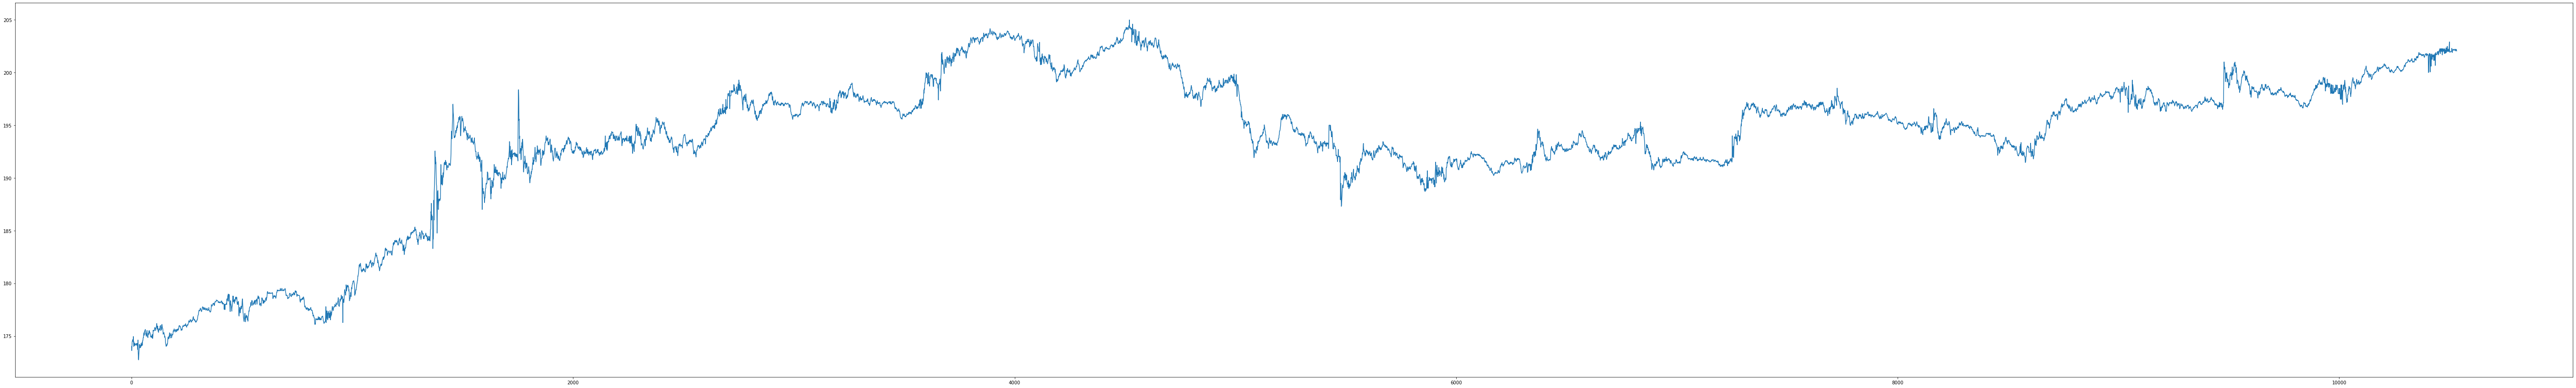

In [30]:
plt.figure(figsize=(100,15))
plt.plot(df.index, df['close'])

#### 3. Perform linear regression on 1 month performers, sort and select top 30

In [5]:
key_df = pd.read_excel('./data/Downloads/25082020screen.xlsx', header=1)
key_df.head()

,Symbol,Company Name,Market Capitalization,Sector,Industry,Dividend Yield,Beta
0,AA,Alcoa Corp,2787930380,Materials,Metals & Mining,--,2.33602
1,AAL,American Airlines Group Inc,6659606290,Industrials,Airlines,--,1.76339
2,AAPL,Apple Inc.,2137410814770,Information Technology,"Technology Hardware, Storage & Peripherals",0.00651531,1.26173
3,ADT,ADT Inc,8663530330,Industrials,Commercial Services & Supplies,0.0123131,--
4,AEO,American Eagle Outfitters Inc,1834567500,Consumer Discretionary,Specialty Retail,0.0492831,1.1967


In [7]:
key_df.rename({'Symbol':'SYMBOL'}, axis=1, inplace=True)

In [9]:
load_set(key_df['SYMBOL'].iloc[0], data_dir, suffix).head()

,open,high,low,close,volume,datetime,date,hour,minute,min_num,SYMBOL,prev_close,diff_1,pct_change,log_return
0,15.05,15.05,15.05,15.05,204126,2020-08-25 22:30:00,2020-08-25,22,30,1350,AA,15.08,-0.03,-0.001989,-0.001991
1,15.08,15.08,15.08,15.08,70,2020-08-25 22:15:00,2020-08-25,22,15,1335,AA,15.00,0.08,0.005333,0.005319
2,15.05,15.05,15.00,15.00,160,2020-08-25 22:04:00,2020-08-25,22,4,1324,AA,15.05,-0.05,-0.003322,-0.003328
3,15.05,15.05,15.05,15.05,179600,2020-08-25 20:40:00,2020-08-25,20,40,1240,AA,15.05,0.00,0.000000,0.000000
4,15.05,15.05,15.05,15.05,1028,2020-08-25 20:39:00,2020-08-25,20,39,1239,AA,15.05,0.00,0.000000,0.000000


In [23]:
stock = 'AA'
data_dir = './data/screens/august25screen/'
suffix = '.pickle'
df = load_set(stock, data_dir, suffix)
df.head()

,open,high,low,close,volume,datetime,date,hour,minute,min_num,SYMBOL,prev_close,diff_1,pct_change,log_return
0,15.05,15.05,15.05,15.05,204126,2020-08-25 22:30:00,2020-08-25,22,30,1350,AA,15.08,-0.03,-0.001989,-0.001991
1,15.08,15.08,15.08,15.08,70,2020-08-25 22:15:00,2020-08-25,22,15,1335,AA,15.00,0.08,0.005333,0.005319
2,15.05,15.05,15.00,15.00,160,2020-08-25 22:04:00,2020-08-25,22,4,1324,AA,15.05,-0.05,-0.003322,-0.003328
3,15.05,15.05,15.05,15.05,179600,2020-08-25 20:40:00,2020-08-25,20,40,1240,AA,15.05,0.00,0.000000,0.000000
4,15.05,15.05,15.05,15.05,1028,2020-08-25 20:39:00,2020-08-25,20,39,1239,AA,15.05,0.00,0.000000,0.000000


In [7]:
df.index.values.reshape(-1,1)

array([[   0],
       [   1],
       [   2],
       ...,
       [9243],
       [9244],
       [9245]])

In [10]:
scores = {}

In [11]:
for sym in key_df['SYMBOL']:
    df = load_set(data_dir=data_dir, stock=sym, tail=suffix)
    y = df['close']
    x = df.index.values.reshape(-1,1)
    
    lr = LinearRegression()
    
    lr.fit(x, y)
    scores[sym] = {'R2_score': lr.score(x, y)}

scores

{'AA': {'R2_score': 0.6049403688595023},
 'AAL': {'R2_score': 0.3547959617883265},
 'AAPL': {'R2_score': 0.8735840323636332},
 'ADT': {'R2_score': 0.11221943610840635},
 'AEO': {'R2_score': 0.4720086080713872},
 'AER': {'R2_score': 0.38631849324479683},
 'AES': {'R2_score': 0.8540315883236411},
 'AGEN': {'R2_score': 0.85934163716742},
 'AM': {'R2_score': 0.7740906120254878},
 'AMC': {'R2_score': 0.83179454821019},
 'AMD': {'R2_score': 0.4421021170303025},
 'APLE': {'R2_score': 0.48126497915141186},
 'APPS': {'R2_score': 0.8635032936415161},
 'AR': {'R2_score': 0.4256523476393691},
 'ARLO': {'R2_score': 0.7508008348568229},
 'ARMK': {'R2_score': 0.46795381802627833},
 'ATEN': {'R2_score': 0.4005812720881619},
 'AVYA': {'R2_score': 0.7953570561725307},
 'AXS': {'R2_score': 0.7526197176594867},
 'BABA': {'R2_score': 0.4079754817510006},
 'BBBY': {'R2_score': 0.5552369911501817},
 'BBY': {'R2_score': 0.9284867446275393},
 'BIG': {'R2_score': 0.8580293050741029},
 'BILI': {'R2_score': 0.239

In [12]:
r2_df = pd.DataFrame(scores).T.reset_index()
r2_df.rename({'index':'SYMBOL'}, axis=1, inplace=True)
r2_df

,SYMBOL,R2_score
0,AA,0.604940
1,AAL,0.354796
2,AAPL,0.873584
3,ADT,0.112219
4,AEO,0.472009
...,...,...
223,YETI,0.362765
224,YNDX,0.864755
225,YY,0.618887
226,Z,0.823265


In [13]:
key_df = key_df.merge(r2_df, how='left', on='SYMBOL')

In [14]:
key_df.head()

,SYMBOL,Company Name,Market Capitalization,Sector,Industry,Dividend Yield,Beta,R2_score
0,AA,Alcoa Corp,2787930380,Materials,Metals & Mining,--,2.33602,0.604940
1,AAL,American Airlines Group Inc,6659606290,Industrials,Airlines,--,1.76339,0.354796
2,AAPL,Apple Inc.,2137410814770,Information Technology,"Technology Hardware, Storage & Peripherals",0.00651531,1.26173,0.873584
3,ADT,ADT Inc,8663530330,Industrials,Commercial Services & Supplies,0.0123131,--,0.112219
4,AEO,American Eagle Outfitters Inc,1834567500,Consumer Discretionary,Specialty Retail,0.0492831,1.1967,0.472009


In [15]:
key_df.sort_values(by='R2_score', ascending=False).head(10)

,SYMBOL,Company Name,Market Capitalization,Sector,Industry,Dividend Yield,Beta,R2_score
174,RRR,Red Rock Resorts Inc,1982589700,Consumer Discretionary,"Hotels, Restaurants & Leisure",--,2.7347,0.949122
49,CZR,Caesars Entertainment Inc,7068654300,Consumer Discretionary,"Hotels, Restaurants & Leisure",--,2.90212,0.941788
152,PACB,Pacific Biosciences of California Inc,1098956100,Health Care,Life Sciences Tools & Services,--,1.92353,0.935568
73,EXPI,eXp World Holdings Inc,2817350520,Real Estate,Real Estate Management & Development,--,2.96643,0.932888
95,HTHT,Huazhu Group Ltd (ADR),12457871160,Consumer Discretionary,"Hotels, Restaurants & Leisure",0.00816915,1.72724,0.931933
21,BBY,Best Buy Co Inc,28978550150,Consumer Discretionary,Specialty Retail,0.0187441,1.69527,0.928487
122,LULU,Lululemon Athletica Inc,49194808740,Consumer Discretionary,"Textiles, Apparel & Luxury Goods",--,1.14523,0.926614
148,NVDA,NVIDIA Corporation,313837050000,Information Technology,Semiconductors & Semiconductor Equipment,0.00125784,1.49245,0.924270
102,ICE,Intercontinental Exchange Inc,56728045760,Financials,Capital Markets,0.0113411,0.58684,0.924002
144,NKE,Nike Inc,174046799020,Consumer Discretionary,"Textiles, Apparel & Luxury Goods",0.0087633,0.82523,0.923488


In [40]:
load_set(data_dir=data_dir, stock='LULU', tail=suffix)

,open,high,low,close,volume,datetime,date,hour,minute,min_num,SYMBOL,prev_close,diff_1,pct_change,log_return
0,378.85,378.85,378.85,378.850,1,2020-08-25 22:57:00,2020-08-25,22,57,1377,LULU,380.000,-1.150,-0.003026,-0.003031
1,380.00,380.00,380.00,380.000,23,2020-08-25 22:56:00,2020-08-25,22,56,1376,LULU,378.850,1.150,0.003036,0.003031
2,378.85,378.85,378.85,378.850,10,2020-08-25 22:54:00,2020-08-25,22,54,1374,LULU,380.000,-1.150,-0.003026,-0.003031
3,380.00,380.00,380.00,380.000,29,2020-08-25 22:52:00,2020-08-25,22,52,1372,LULU,379.500,0.500,0.001318,0.001317
4,378.58,379.52,378.58,379.500,9,2020-08-25 22:38:00,2020-08-25,22,38,1358,LULU,380.000,-0.500,-0.001316,-0.001317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8641,323.54,324.00,323.12,323.650,800,2020-07-27 13:32:00,2020-07-27,13,32,812,LULU,323.785,-0.135,-0.000417,-0.000417
8642,324.74,325.09,323.66,323.785,3561,2020-07-27 13:31:00,2020-07-27,13,31,811,LULU,325.270,-1.485,-0.004565,-0.004576
8643,324.28,325.39,323.99,325.270,15918,2020-07-27 13:30:00,2020-07-27,13,30,810,LULU,322.000,3.270,0.010155,0.010104
8644,322.00,322.00,322.00,322.000,200,2020-07-27 12:51:00,2020-07-27,12,51,771,LULU,324.510,-2.510,-0.007735,-0.007765


In [6]:
import math

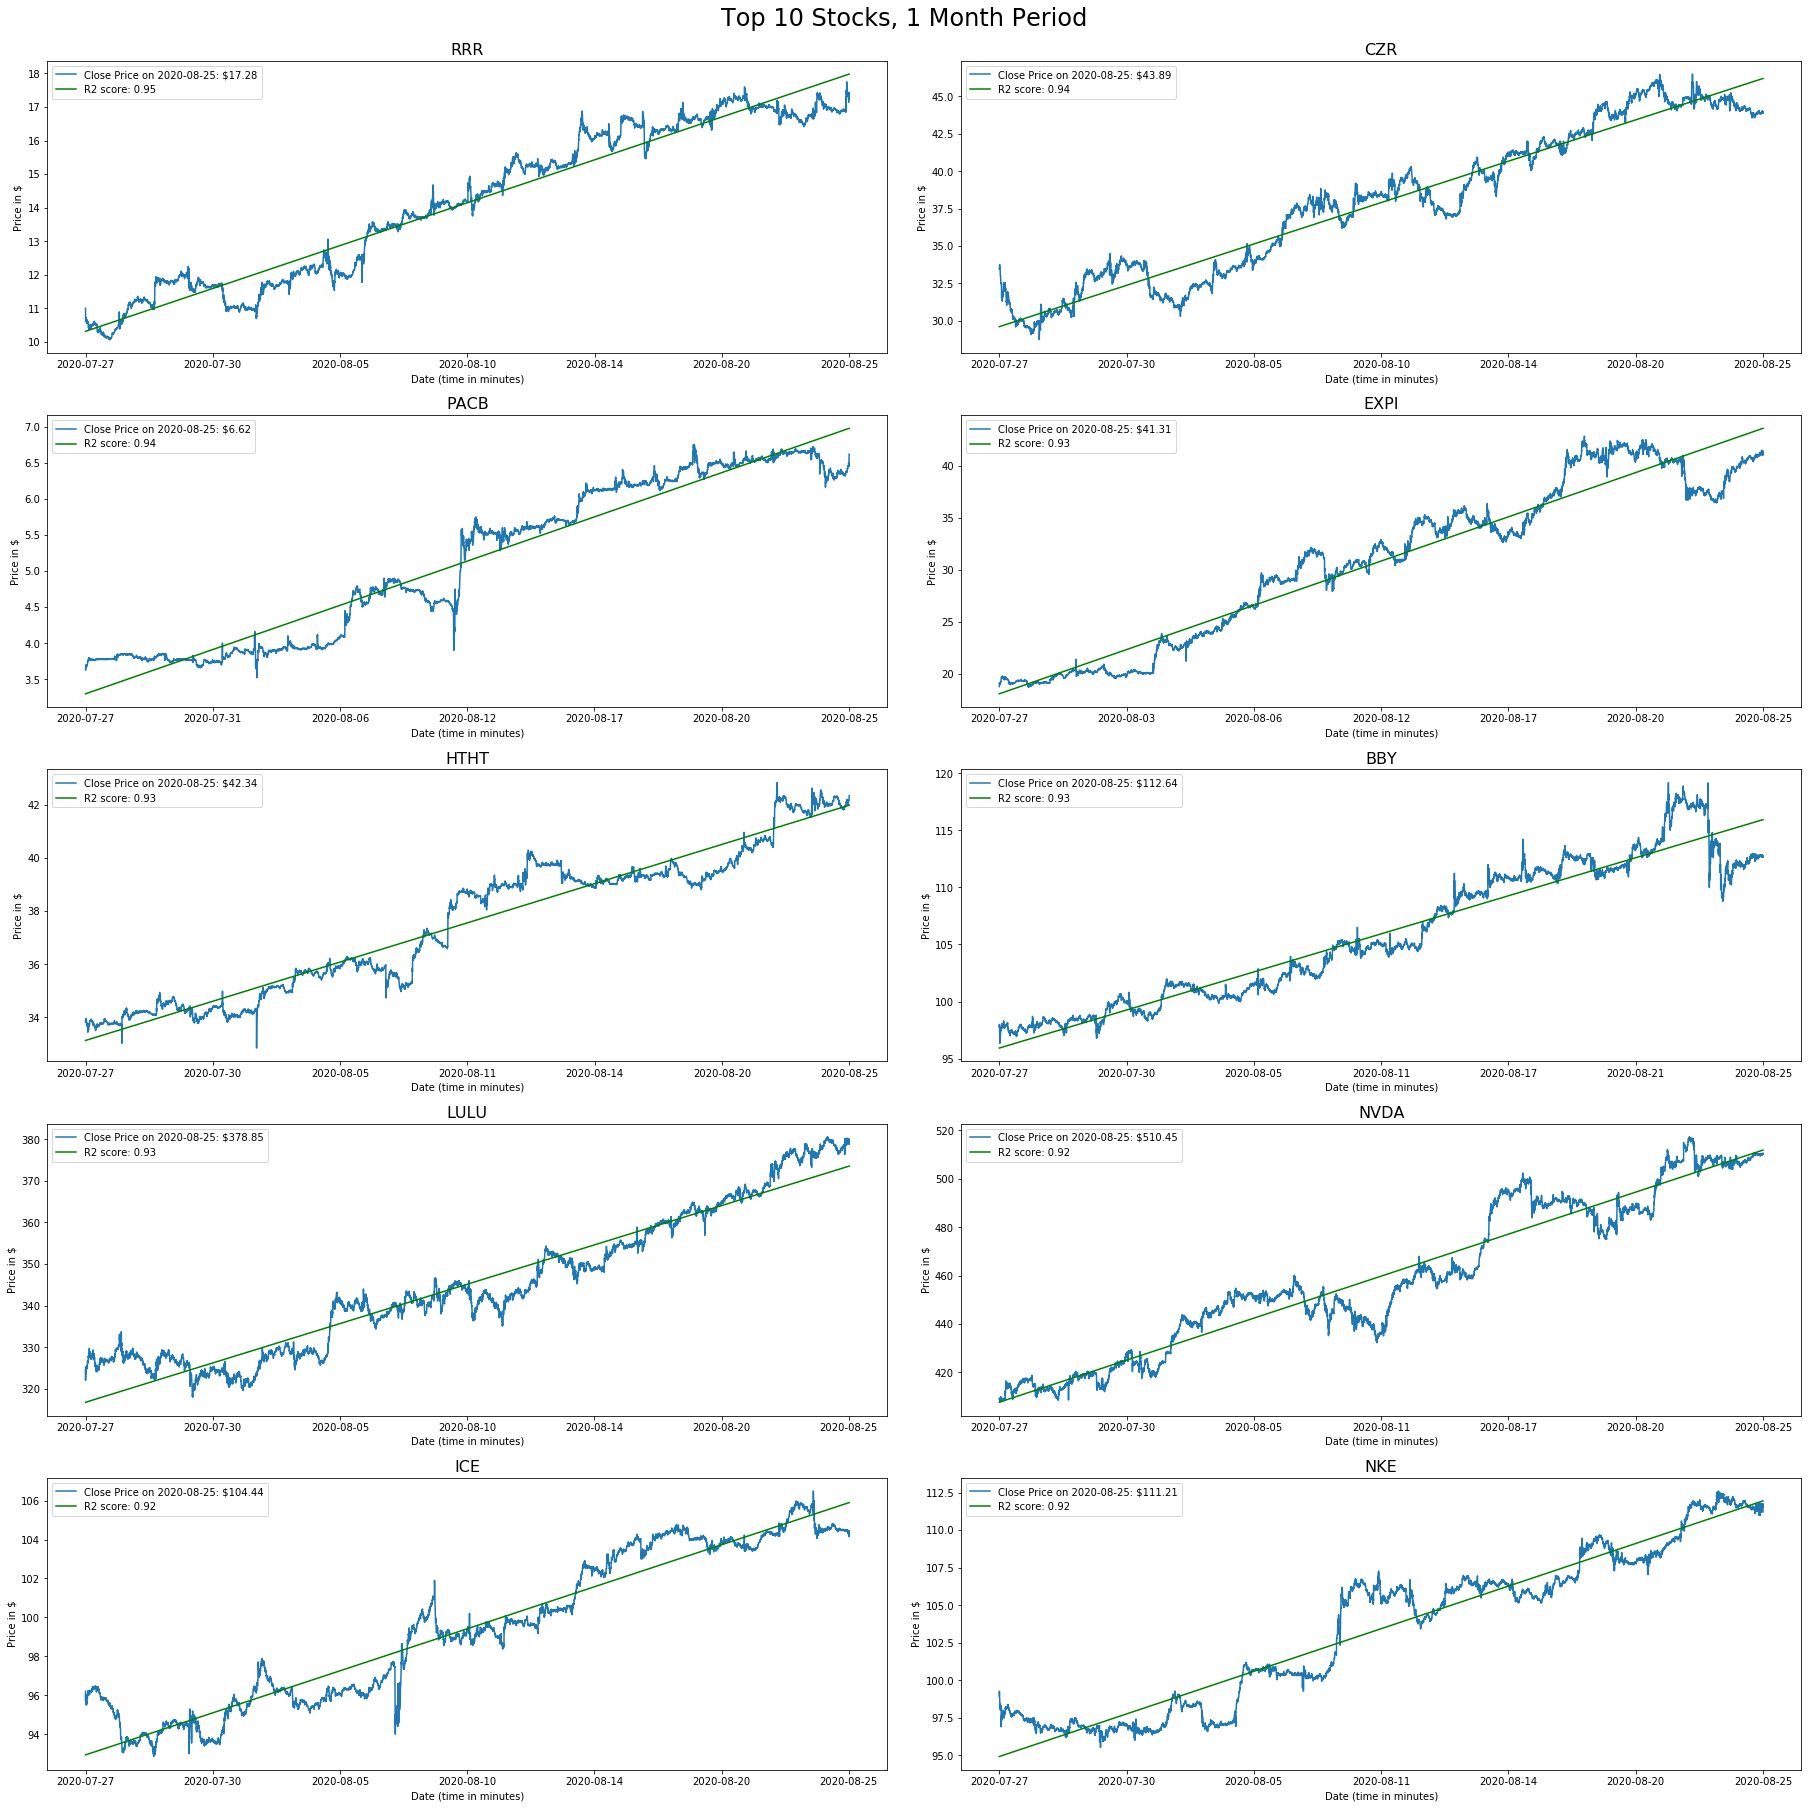

In [43]:
top_10 = key_df.sort_values(by='R2_score', ascending=False).head(10)['SYMBOL']
fig, axs = plt.subplots(5, 2, figsize=(25,25), constrained_layout=True)
fig.suptitle('Top 10 Stocks, 1 Month Period', fontsize = 24)
for i, sym in enumerate(top_10):
    c = divmod(i, 2)
    df = load_set(data_dir=data_dir, stock=sym, tail=suffix)
    df = df[::-1].reset_index(drop=True)
    y = df['close']
    x = df.index.values.reshape(-1,1)
    
    lr = LinearRegression()
    
    lr.fit(x, y)
    scores[sym] = lr.score(x, y)
    y_pred = lr.predict(x)
    
    axs[c[0], c[1]].plot(df.index, df['close'], label='Close Price on {}: ${}'.format(df.iloc[-1]['date'], df.iloc[-1]['close']))
    axs[c[0], c[1]].plot(df.index, y_pred, label='R2 score: {:.2f}'.format(scores[sym]), c='g')
    axs[c[0], c[1]].set_title(sym, fontsize= 16)
    axs[c[0], c[1]].set_ylabel('Price in $')
    axs[c[0], c[1]].set_xlabel('Date (time in minutes)')
    
    plt.sca(axs[c[0], c[1]])
    length = df.shape[0] -1
    locs = [math.floor(length/6)*i for i in range(7)]
    ticks = [df.loc[val, 'date'] for val in locs]
    plt.xticks(locs, ticks)
    
    axs[c[0], c[1]].legend()
plt.savefig('./data/images/1monthstocks.png', transparent=False)

In [21]:
key_df

,SYMBOL,Company Name,Market Capitalization,Sector,Industry,Dividend Yield,Beta,R2_score
0,AA,Alcoa Corp,2787930380,Materials,Metals & Mining,--,2.33602,0.604940
1,AAL,American Airlines Group Inc,6659606290,Industrials,Airlines,--,1.76339,0.354796
2,AAPL,Apple Inc.,2137410814770,Information Technology,"Technology Hardware, Storage & Peripherals",0.00651531,1.26173,0.873584
3,ADT,ADT Inc,8663530330,Industrials,Commercial Services & Supplies,0.0123131,--,0.112219
4,AEO,American Eagle Outfitters Inc,1834567500,Consumer Discretionary,Specialty Retail,0.0492831,1.1967,0.472009
...,...,...,...,...,...,...,...,...
223,YETI,Yeti Holdings Inc,4494988260,Consumer Discretionary,Leisure Products,--,--,0.362765
224,YNDX,Yandex NV,23454958000,Communication Services,Interactive Media & Services,--,1.64555,0.864755
225,YY,JOYY Inc (ADR),7606390410,Communication Services,Interactive Media & Services,0.00069004,1.21145,0.618887
226,Z,ZILLOW GROUP INC,13231041800,Communication Services,Interactive Media & Services,--,1.32823,0.823265


In [18]:
data_dir

'./data/screens/august25screen/'

In [16]:
fn = 'key'
key_df.to_csv('{}{}.csv'.format(data_dir, fn), index=False)

#### 4. Transform selected top 30 by implementing engineered features

In [29]:
fn = 'key'
key_df = pd.read_csv('{}{}.csv'.format(data_dir, fn))
key_df.head()

,SYMBOL,Company Name,Market Capitalization,Sector,Industry,Dividend Yield,Beta,R2_score
0,AA,Alcoa Corp,2787930380,Materials,Metals & Mining,--,2.33601999282837,0.604940
1,AAL,American Airlines Group Inc,6659606290,Industrials,Airlines,--,1.76338994503021,0.354796
2,AAPL,Apple Inc.,2137410814770,Information Technology,"Technology Hardware, Storage & Peripherals",0.00651531,1.26172995567322,0.873584
3,ADT,ADT Inc,8663530330,Industrials,Commercial Services & Supplies,0.0123131,--,0.112219
4,AEO,American Eagle Outfitters Inc,1834567500,Consumer Discretionary,Specialty Retail,0.04928315,1.19669997692108,0.472009


In [30]:
top_30 = key_df.sort_values(by='R2_score', ascending=False).head(30)['SYMBOL']
top_30.iloc[0]

'RRR'

In [31]:
tail = '.pickle'
df = load_set(top_30.iloc[0],data_dir, tail)
df.head()

,open,high,low,close,volume,datetime,date,hour,minute,min_num,SYMBOL,prev_close,diff_1,pct_change,log_return
0,17.28,17.28,17.28,17.28,100,2020-08-25 22:48:00,2020-08-25,22,48,1368,RRR,17.30,-0.02,-0.001156,-0.001157
1,17.30,17.30,17.30,17.30,200,2020-08-25 22:44:00,2020-08-25,22,44,1364,RRR,17.44,-0.14,-0.008028,-0.008060
2,17.35,17.44,17.35,17.44,25,2020-08-25 22:36:00,2020-08-25,22,36,1356,RRR,17.35,0.09,0.005187,0.005174
3,17.35,17.35,17.35,17.35,4,2020-08-25 22:34:00,2020-08-25,22,34,1354,RRR,17.32,0.03,0.001732,0.001731
4,17.32,17.32,17.32,17.32,499,2020-08-25 22:28:00,2020-08-25,22,28,1348,RRR,17.32,0.00,0.000000,0.000000


In [32]:
save_dir = './data/prepared/august25screenfixed/'
print("Loading data from: {}".format(data_dir))
print("Saving data to: {}".format(save_dir))

Loading data from: ./data/screens/august25screen/
Saving data to: ./data/prepared/august25screenfixed/


In [33]:
def fit_sine(x):
    '''Fit sin to the input time sequence, 
    and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    # y = x.index
    yy = numpy.array(x)
    tt = numpy.array(x.index.values)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A *numpy.sin(w*t + p) + c
    
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess, maxfev=10000)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    
    # Original return function
    # Needs to be modified to return a single number value
#     return {"amp": A, 
#             "omega": w, 
#             "phase": p, 
#             "offset": c, 
#             "freq": f, 
#             "period": 1./f, 
#             "fitfunc": fitfunc, 
#             "maxcov": numpy.max(pcov),}, #index=[x.index.values[0]]
#             "rawres": (guess,popt,pcov)}
    #print(tt[0], tt[0]+1)
    
    ### Use this section if you want to insert the extraneous features into the external dataframe ### 
    internal = pd.Series({"amp": A, 
                "omega": w, 
                "phase": p, 
                "offset": c, 
                "freq": f, 
                "period": 1./f, 
                "fitfunc": fitfunc, 
                "maxcov": numpy.max(pcov)})
    df.loc[tt[-1], internal.index] = internal
    ### ---------- ### 
    
    return fitfunc(tt[-1])

In [37]:
drop_cols = ['open_fitfunc', 'high_fitfunc', 'low_fitfunc', 'close_fitfunc']

for stock in top_30:
    start = time.time()
    print('Beginning stock {}'.format(stock))
    
    df = load_set(stock, data_dir, tail)
    df = df[::-1].reset_index(drop=True)[::-1]
    cols = ['open','high','low','close']
    
    
    for col in cols:
        # setup % change columns
        df['%{}'.format(col)] = df[col].diff(-1) / df[col].shift(-1)

        # Apply Mesa sine wave to columns
        df['mesa_{}'.format(col)] = df[col][::-1].rolling(5).apply(mesa_wave, raw=True)[::-1]

        new_cols = ["amp", "omega", "phase", "offset","freq","period","fitfunc","maxcov"]
        for new in new_cols:
            df[new] = pd.Series()


        df['{}_sin'.format(col)] = df['%{}'.format(col)][::-1].dropna().rolling(25).apply(fit_sine, raw=False)[::-1]
        df.rename({new:'{}_{}'.format(col, new) for new in new_cols}, axis=1, inplace=True)
        df['time'] = df.index

        df['{}_angle'.format(col)] = df['{}_omega'.format(col)] * df['time'].astype(int) + df['{}_phase'.format(col)]

        df['{}_rad'.format(col)] = np.remainder(df['{}_angle'.format(col)], 2*np.pi)

        df['{}_rad2'.format(col)] = df['{}_omega'.format(col)] / (2*np.pi) + df['{}_rad'.format(col)]
        df['{}_sin2'.format(col)] = df['{}_amp'.format(col)] * np.sin(df['{}_rad2'.format(col)]) + df['{}_offset'.format(col)]
        df['{}_cos2'.format(col)] = np.cos(df['{}_rad2'.format(col)])
        df['{}_cos'.format(col)] = np.cos(df['{}_rad'.format(col)])
        df['{}_tan'.format(col)] = np.tan(df['{}_rad'.format(col)])
        df['{}_tan2'.format(col)] = np.tan(df['{}_rad2'.format(col)])

        df['{}_xsinx'.format(col)] = df['%{}'.format(col)] * df['{}_sin'.format(col)]
        df['{}_xcosx'.format(col)] = df['%{}'.format(col)] * df['{}_cos'.format(col)]
        df['{}_sinxcosx'.format(col)] = df['{}_sin'.format(col)] * df['{}_cos'.format(col)]
        df['{}_xsinxcosx'.format(col)] =df['%{}'.format(col)] * df['{}_sin'.format(col)] * df['{}_cos'.format(col)]

        df['{}_xsinx2'.format(col)] = df['%{}'.format(col)] * df['{}_sin2'.format(col)]
        df['{}_xcosx2'.format(col)] = df['%{}'.format(col)] * df['{}_cos2'.format(col)]
        df['{}_sinxcosx2'.format(col)] = df['{}_sin2'.format(col)] * df['{}_cos2'.format(col)]
        df['{}_xsinxcosx2'.format(col)] =df['%{}'.format(col)] * df['{}_sin2'.format(col)] * df['{}_cos2'.format(col)]

        df['{}_xtanx'.format(col)] = df['%{}'.format(col)] * df['{}_tan'.format(col)]
        df['{}_xtanx2'.format(col)] = df['%{}'.format(col)] * df['{}_tan2'.format(col)]
        
    
    df.drop(drop_cols, axis=1).to_pickle("{}{}{}".format(save_dir, stock, tail))
    end = time.time()
    print("{} complete: {}".format(stock, end - start))

Beginning stock RRR


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


RRR complete: 186.79309940338135
Beginning stock CZR


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


CZR complete: 224.9565510749817
Beginning stock PACB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


PACB complete: 184.78114080429077
Beginning stock EXPI


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


EXPI complete: 184.46695232391357
Beginning stock HTHT


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


HTHT complete: 177.43932700157166
Beginning stock BBY


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


BBY complete: 226.40686774253845
Beginning stock LULU


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


LULU complete: 246.85642528533936
Beginning stock NVDA


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


NVDA complete: 335.97553062438965
Beginning stock ICE


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


ICE complete: 189.0561056137085
Beginning stock NKE


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


NKE complete: 222.11351823806763
Beginning stock PENN


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


PENN complete: 286.4257369041443
Beginning stock RLGY


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


RLGY complete: 260.7773017883301
Beginning stock MIK


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


MIK complete: 209.6650731563568
Beginning stock DHI


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


DHI complete: 202.91262030601501
Beginning stock FBHS


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


FBHS complete: 179.60264921188354
Beginning stock REAL


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


REAL complete: 202.0819320678711
Beginning stock EAT


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


EAT complete: 200.3174126148224
Beginning stock XRX


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


XRX complete: 205.97825622558594
Beginning stock LOW


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


LOW complete: 343.6450755596161
Beginning stock CLNY


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


CLNY complete: 288.60610008239746
Beginning stock HOME


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


HOME complete: 283.43574118614197
Beginning stock GDDY


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


GDDY complete: 193.04363346099854
Beginning stock FDX


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


FDX complete: 215.17217826843262
Beginning stock TGT


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


TGT complete: 229.99555087089539
Beginning stock WSM


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


WSM complete: 195.38265752792358
Beginning stock IMVT


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


IMVT complete: 131.92955803871155
Beginning stock ELAN


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


ELAN complete: 211.02075576782227
Beginning stock GRPN


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


GRPN complete: 224.61739230155945
Beginning stock CX


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


CX complete: 182.47532320022583
Beginning stock DE


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


DE complete: 195.1747546195984


In [38]:
## Because the code broke, I need to update my list by removing those files that completed
from os import listdir
from os.path import isfile, join
mypath = save_dir
onlyfiles = [f.split('.')[0] for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles
top_30 = list(top_30)
for f in onlyfiles:
    try:
        top_30.remove(f)
    except:
        pass
len(top_30)

0

In [39]:
top_30

[]

#### 5. Save